In [1]:
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
%matplotlib inline

In [2]:
# Create mesh and define function space
mesh = df.UnitSquareMesh(2, 2)
V = df.FunctionSpace(mesh, 'CG', 1)
Vc = df.FunctionSpace(mesh,'DG', 0)

# Define Dirichlet boundary (x = 0 or x = 1)
def dirichletBoundary(x):
    return x[0] < df.DOLFIN_EPS or x[0] > 1.0 -df.DOLFIN_EPS

# Define Dirichlet boundary condition
u0 = df.Expression('10.0*x[1] + 2.0', degree=1)
bc = df.DirichletBC(V, u0, dirichletBoundary, method='pointwise')

#Define Neumann boundary condition
u_x = '0.0-2.0*x[1]'
u_y = '1.0-2.0*x[0]'
flowField = df.Expression((u_x, u_y), degree=2)
bcFlux = df.inner(df.FacetNormal(mesh), flowField)

#Heat source
sourceTerm = df.Expression('0.0', degree=1)


theta = df.Function(Vc)
theta.vector()[:] = 1 + np.abs(np.random.normal(0,0.0,Vc.dim()))

# Define variational problem
u = df.TrialFunction(V)
v = df.TestFunction(V)
#f = df.Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)",degree=2)
#a = theta * df.inner(df.grad(u), df.grad(v))*df.dx
#L = f * v * df.dx

a = theta * df.inner(df.grad(v), df.grad(u)) * df.dx
L = sourceTerm * v * df.dx + bcFlux * v * df.ds

# Compute solution
u = df.Function(V)
df.solve(a == L, u, bc)

print(u.vector().get_local())

[ 12.    7.    9.5   2.    7.   12.    4.5   7.    2. ]


In [3]:
# For repeated finite difference evaluation
def ForwardSolver(x):
    
    uu = df.TrialFunction(V)
    vv = df.TestFunction(V)
    thetal = df.Function(Vc)
    thetal.vector()[:] = x
    aa = thetal * df.inner(df.grad(uu), df.grad(vv)) * df.dx
    LL = sourceTerm * vv * df.dx + bcFlux * vv * df.ds
    uu = df.Function(V)
    df.solve(aa == LL, uu, bc)
    return uu.vector().get_local()

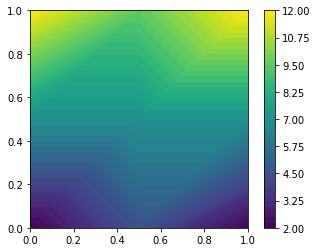

In [4]:
# Plot of solution
pu = df.plot(u)
plt.colorbar(pu)

In [5]:
# Make up bogus functional
#H = np.random.normal(0,1,(V.dim(), V.dim()))
#H = H + H.T + np.eye(V.dim())
H = np.eye(V.dim())

# A functional of the solution which by construction has H as the Hessian
def Functional(x):
    return - 0.5 * x.dot(H.dot(x))

In [6]:
# Get Finite Difference Vector
h = 1e-6

x0 = theta.vector().get_local()
grad_fd = np.zeros(Vc.dim())

for i in range(Vc.dim()):
    xp = x0.copy()
    xm = x0.copy()
    
    xp[i] = xp[i] + h
    xm[i] = xm[i] - h
        
    upv = ForwardSolver(xp)
    Lp = Functional(upv)
    
    upm = ForwardSolver(xm)
    Lm = Functional(upm)
    
    grad_fd[i] = (Lp - Lm)/(2*h)

In [7]:
# derivative of residual wrt u
K = df.assemble(a)

# we need to apply boundary condition to K
bc.apply(K)
K = K.array()
print('K = ', K)

# derivative of functional wrt u
b = -H.dot(u.vector().get_local())

# get adjoints
adjoints = np.linalg.solve(K.T, b)

K =  [[ 1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5  0.   2.   0.  -1.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.  -1.  -1.   0.   4.   0.  -1.  -1.   0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5 -1.   0.   2.   0.  -0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1. ]]
adjoints ==  [-15.54166667 -11.66666667  -7.08333333  -4.29166667  -4.66666667
 -15.54166667  -4.58333333 -11.66666667  -4.29166667]


We compute finite difference gradients for the stiffness matrix K. K is linear in theta, i.e. finite difference gradients are exact and constant.

We later use them in the adjoint equation
$dJ/d\theta_i = \lambda^T(\frac{dF}{d\theta_i} - \frac{dK}{d\theta_i} u)$, where

$\lambda = K^{-T} \nabla_u J$ and

$Ku - F = 0$ the FEM equation system.

In [8]:
h = 1e-4
d_K_list = []
grad_K_fd = np.zeros(Vc.dim())
theta_0 = theta.vector().get_local().copy()
for i in range(0, Vc.dim()):
    theta_temp = df.Function(Vc)
    theta_temp_vec = theta_0.copy()
    theta_temp_vec[i] += h
    theta_temp.vector().set_local(theta_temp_vec)
    w = df.TrialFunction(V)
    a_temp = theta_temp * df.inner(df.grad(v), df.grad(w)) * df.dx
    K_temp = df.assemble(a_temp)

    # we need to apply boundary condition to finite difference K
    bc.apply(K_temp)
    K_temp = K_temp.array()
    d_K_temp = (K_temp - K)/h
    d_K_list.append(d_K_temp)
    d_i = - adjoints.dot(d_K_temp)
    grad_K_fd[i] = d_i.dot(u.vector().get_local())
#print('dK_dtheta0 = ', d_K_list[0])

In [9]:
print('d_K == ', d_K_temp)
print(d_K_temp.shape)
d_K_coo = sp.coo_matrix(d_K_temp)
d_K_csr = sp.csr_matrix(d_K_temp)
d_K_csc = sp.csc_matrix(d_K_temp)
%timeit d_K_temp.dot(adjoints)
%timeit d_K_coo.dot(adjoints)
%timeit d_K_csr.dot(adjoints)
%timeit d_K_csc.dot(adjoints)

d_K ==  [[ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.  -0.5 -0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0. ]]
(9, 9)
685 ns ± 10.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
6.94 µs ± 41.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.85 µs ± 61.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.87 µs ± 87.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


$dK/d\theta_0$:

d1 $= dK/d\theta_0$. It is the correct one, i.e. identical to the f.d. gradient below.

In [10]:
# derivative of r wrt theta
# the trick is that here we are not using u as trial functions, but instead as function
r = theta * df.inner(df.grad(u), df.grad(v)) * df.dx    # the part of the residual that depends on theta

In [11]:
dr_dtheta = df.assemble(df.derivative(r, theta))
#bc.apply(dr_dtheta)
dr_dtheta = dr_dtheta.array()
print('dr_dtheta = ', dr_dtheta)

dr_dtheta =  [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   3.75000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.50000000e+00   0.00000000e+00   0.00000000e+00
   -4.44089210e-16  -2.50000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    1.25000000e+00  -1.25000000e+00   0.00000000e+00  -4.44089210e-16]
 [ -1.25000000e+00  -2.50000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  1.25000000e+00   4.44089210e-16   0.00000000e+00   1.25000000e+00
   -1.25000000e+00   0.00000000e+00   4.44089210e-16  -1.25000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   2.50000000e+00   1.25000000e+00]
 [ -4.44089210e-16   0.00000000e+00   1.25000000e+00  -1.25000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


In [12]:
grad_adjoint = - adjoints.dot(dr_dtheta)

In [13]:
print("Relative Error (L2): {}".format(np.linalg.norm(grad_fd - grad_adjoint)/np.linalg.norm(grad_fd)))

Relative Error (L2): 3.140741856531106


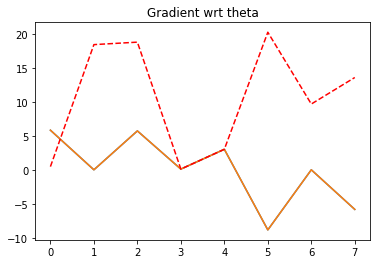

In [14]:
plt.plot(grad_fd)
plt.plot(grad_K_fd)
plt.plot(grad_adjoint,'r--')
plt.title('Gradient wrt theta');

In [15]:
print('fd_grad = ', grad_fd)
print('grad_K_fd = ', grad_K_fd)
print('grad = ', grad_adjoint)
print('rel. grad = ', grad_adjoint/grad_fd)


fd_grad =  [ 5.83333332  0.          5.72916667  0.10416667  3.0208333  -8.85416662
  0.         -5.83333338]
grad_K_fd =  [  5.83333333e+00   3.55271368e-15   5.72916667e+00   1.04166667e-01
   3.02083333e+00  -8.85416667e+00   3.55271368e-15  -5.83333333e+00]
grad =  [  0.46875     18.4375      18.80208333   0.10416667   3.02083333
  20.26041667   9.6875      13.59375   ]
rel. grad =  [ 0.08035714         inf  3.28181818  0.99999993  1.00000001 -2.28823531
         inf -2.33035713]


/home/constantin/.conda/envs/pyadjoint/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


In [46]:
cll = df.Cell(mesh, 0)
print(cll.volume())
a = np.array([.1, .1])
pt = df.Point(a)
print(cll.contains(pt))

0.125
True


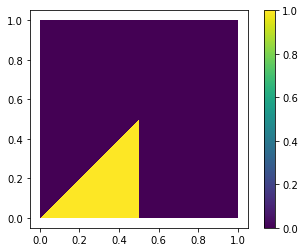

In [50]:
constFun = df.Function(Vc)
constFun.vector()[0] = 1.0
pl = df.plot(constFun)
plt.colorbar(pl)